In [1]:
#imports
import os
import scipy.io
import numpy as np
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,KFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
#Data preprocessing and analysing
data_dir = 'CW-Data/'

summary_stats = []

for file_name in os.listdir(data_dir):
    if file_name.endswith('.mat'):
        file_path = os.path.join(data_dir, file_name)
        data = scipy.io.loadmat(file_path)
        
        key_name = next(key for key in data.keys() if not key.startswith('__'))
        features = data[key_name]
        
        mean_features = np.mean(features, axis=0)
        std_features = np.std(features, axis=0)
        
        summary_stats.append({
            'File Name': file_name,
            'Mean': mean_features.tolist(),
            'Std Dev': std_features.tolist(),
            'Shape': features.shape
        })

summary_df = pd.DataFrame(summary_stats)
summary_df.to_csv('dataset_summary.csv', index=False)
print("Summary saved to 'dataset_summary.csv'")

Summary saved to 'dataset_summary.csv'


In [ ]:
#Combine Feature Vectors
all_features = []
all_labels = []

user_count = 10
feature_files_per_user = 6

for user_id in range(1, user_count + 1):
    for feature_idx in range(feature_files_per_user):
        file_name = f"U{str(user_id).zfill(2)}_Acc_FreqD_FDay.mat"
        file_path = os.path.join(data_dir, file_name)

        data = scipy.io.loadmat(file_path)
        key_name = next(key for key in data.keys() if not key.startswith('__'))
        features = data[key_name]

        all_features.append(features)
        all_labels.extend([user_id - 1] * features.shape[0]) 

all_features = np.vstack(all_features)
all_labels = np.array(all_labels)

print("Combined dataset shape:", all_features.shape)
print("Labels shape:", all_labels.shape)

Combined dataset shape: (2160, 43)
Labels shape: (2160,)


In [5]:
#Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(
    all_features, all_labels, test_size=0.2, random_state=42
)
print(f"Training data shape: {X_train.shape}, Testing data shape: {X_test.shape}")

Training data shape: (1728, 43), Testing data shape: (432, 43)


In [ ]:
#Design and Train the Neural Network
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/50
49/49 [==============================] - 1s 6ms/step - loss: 2.2219 - accuracy: 0.2135 - val_loss: 2.0626 - val_accuracy: 0.5376
Epoch 2/50
49/49 [==============================] - 0s 2ms/step - loss: 1.8494 - accuracy: 0.4707 - val_loss: 1.5830 - val_accuracy: 0.5896
Epoch 3/50
49/49 [==============================] - 0s 3ms/step - loss: 1.4044 - accuracy: 0.6084 - val_loss: 1.1689 - val_accuracy: 0.7399
Epoch 4/50
49/49 [==============================] - 0s 3ms/step - loss: 1.0821 - accuracy: 0.7125 - val_loss: 0.9472 - val_accuracy: 0.6532
Epoch 5/50
49/49 [==============================] - 0s 2ms/step - loss: 0.8528 - accuracy: 0.7820 - val_loss: 0.7414 - val_accuracy: 0.7803
Epoch 6/50
49/49 [==============================] - 0s 2ms/step - loss: 0.6959 - accuracy: 0.8077 - val_loss: 0.6058 - val_accuracy: 0.8208
Epoch 7/50
49/49 [==============================] - 0s 3ms/step - loss: 0.5999 - accuracy: 0.8360 - val_loss: 0.5166 - val_accuracy: 0.8671
Epoch 8/50
49/49 [==

14/14 [==============================] - 0s 1ms/step


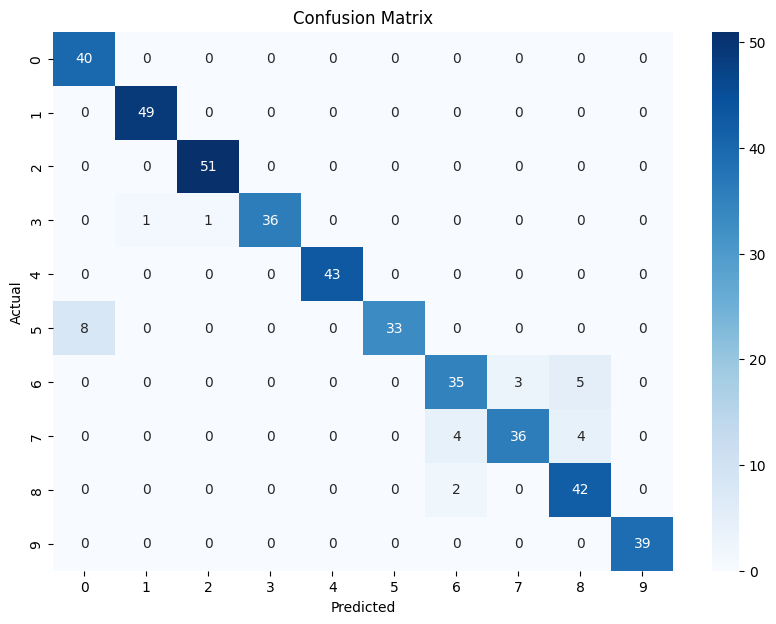

              precision    recall  f1-score   support

           0       0.83      1.00      0.91        40
           1       0.98      1.00      0.99        49
           2       0.98      1.00      0.99        51
           3       1.00      0.95      0.97        38
           4       1.00      1.00      1.00        43
           5       1.00      0.80      0.89        41
           6       0.85      0.81      0.83        43
           7       0.92      0.82      0.87        44
           8       0.82      0.95      0.88        44
           9       1.00      1.00      1.00        39

    accuracy                           0.94       432
   macro avg       0.94      0.93      0.93       432
weighted avg       0.94      0.94      0.93       432



In [ ]:
# Evaluate and Optimize-Confusion Matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred))

In [8]:
#Optimization - Cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train[train_index], X_train[val_index]
    y_fold_train, y_fold_val = y_train[train_index], y_train[val_index]
    model.fit(X_fold_train, y_fold_train, epochs=20, batch_size=32, validation_data=(X_fold_val, y_fold_val))

Epoch 1/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1703 - accuracy: 0.9407 - val_loss: 0.1928 - val_accuracy: 0.9277
Epoch 2/20
44/44 [==============================] - 0s 2ms/step - loss: 0.1760 - accuracy: 0.9370 - val_loss: 0.2105 - val_accuracy: 0.8960
Epoch 3/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1768 - accuracy: 0.9342 - val_loss: 0.2266 - val_accuracy: 0.8988
Epoch 4/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1743 - accuracy: 0.9356 - val_loss: 0.2150 - val_accuracy: 0.9162
Epoch 5/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1752 - accuracy: 0.9334 - val_loss: 0.1889 - val_accuracy: 0.9162
Epoch 6/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1581 - accuracy: 0.9385 - val_loss: 0.1916 - val_accuracy: 0.9162
Epoch 7/20
44/44 [==============================] - 0s 3ms/step - loss: 0.1628 - accuracy: 0.9407 - val_loss: 0.1897 - val_accuracy: 0.9162
Epoch 8/20
44/44 [==

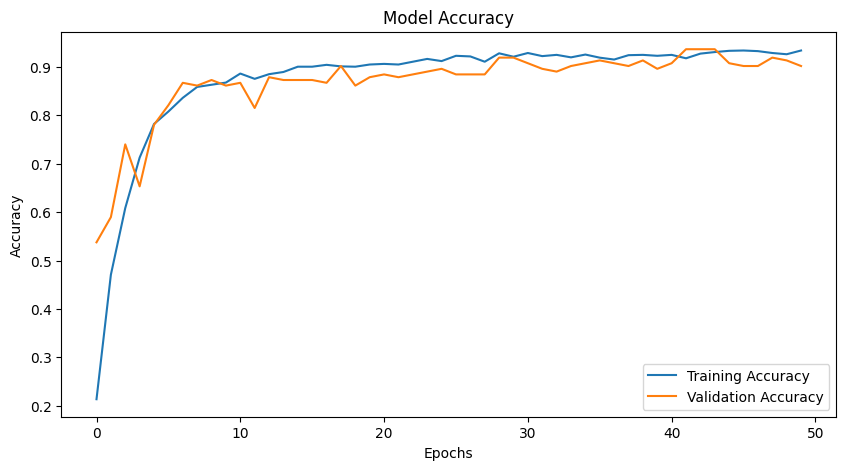

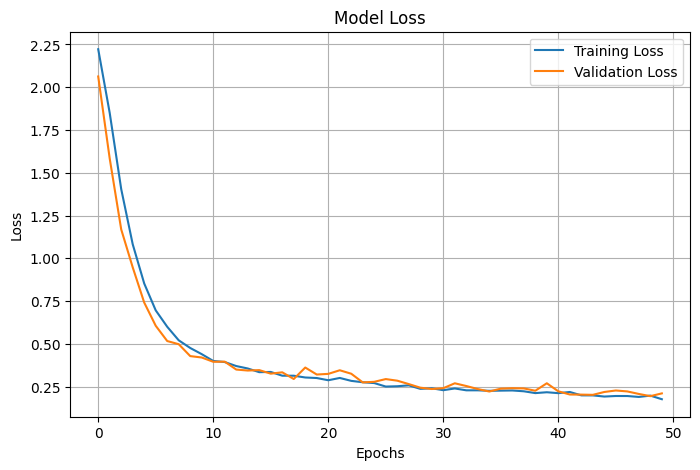

In [9]:
#Visualization of results-

# Accuracy Plot
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.show()

#Loss curve
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()